In [3]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
#import random
import geopandas as gpd
#import folium
import matplotlib.pyplot as plt

In [4]:
#Load density and ward data
df_density = pd.read_csv('./data/density.csv')
df_wards = pd.read_csv('./data/LSOA_WARD.csv')
df_geopandas_lsoa = gpd.read_file("./data/barnet_lsoa.geojson")
filepath_met = "./data/predictions_12months_from_2022-04-01 00:00:00"

# read the Parquet file into a pandas dataframe
df = pq.read_pandas(filepath_met).to_pandas()
df = df.transpose()
#df.columns = df.iloc[0]
#df = df.iloc[1:]
df
df_predicted_crimes = df

#Merge wards and geopandas data
df_geopandas_ward = pd.merge(left=df_wards, right=df_geopandas_lsoa, left_on='LSOA21NM', right_on='LSOA11NM')

#Select wards in Barnet
df_wards=df_wards[["LSOA21NM","WD22NM"]]
df_wards= df_wards[df_wards['LSOA21NM'].str.contains('Barnet')==True]


#Merge density data with Barnet wards
df_barnet = pd.merge(left=df_density, right=df_wards, left_on='LSOA Name', right_on='LSOA21NM')
df_barnet['Mid-2020 population'] = df_barnet['Mid-2020 population'].str.replace(',', '.').astype(float)

#Calculate people per sq km in wards in Barnet
df_barnet = df_barnet[['Mid-2020 population', 'Area Sq Km', 'WD22NM']].groupby('WD22NM').sum()
df_barnet['People per Sq Km'] = df_barnet['Mid-2020 population']/df_barnet['Area Sq Km']


#Select month for crimes in Barnet wards
crimes_in_wards = df_predicted_crimes.iloc[:,-1].astype(float)

df_barnet['predicted crimes'] = crimes_in_wards


#Calculate proportion of crimes in a ward
df_barnet['crimes proportion'] = df_barnet['predicted crimes']/df_barnet['People per Sq Km']
crimes_tot = df_barnet['crimes proportion'].sum()
df_barnet['crimes proportion'] = df_barnet['crimes proportion']/crimes_tot



#Available police force
police_officers = 100 - 23

#Allocate police to wards
df_barnet['allocated police'] = df_barnet['crimes proportion'] * police_officers

df_barnet['allocated police'] = df_barnet['allocated police'].astype(int) + 1




df_barnet.head()

#Select relevant columns
df_geopandas = pd.merge(left=df_geopandas_ward, right=df_barnet, left_on='WD22NM', right_on=df_barnet.index)

df_geopandas = df_geopandas[['WD22NM', 'geometry', 'People per Sq Km', 'predicted crimes', 'crimes proportion', 'allocated police']]

df_geopandas
#DOESNT ALWAYS ADD UP TO 100!


df_geopandas_grouped = df_geopandas[['WD22NM', 'predicted crimes']].groupby('WD22NM').count()
df_geopandas_summed = df_geopandas[['WD22NM', 'predicted crimes']].groupby('WD22NM').sum()
df_geopandas_summed
final =  df_geopandas_summed['predicted crimes']/df_geopandas_grouped['predicted crimes']


In [5]:
#Make sure the allocated police is 100 in the end

def calc_prob(probabilities):
    # Step 2: Calculate the sum of probabilities
    sum_of_probabilities = sum(probabilities)

    # Step 3: Scale the probabilities
    scaled_probabilities = [(max(round(prob * (100/sum_of_probabilities)), 2)) for prob in probabilities]

    # Step 4: Adjust rounding errors and ensure the sum is 100
    error = 100 - sum(scaled_probabilities)
    if error > 0:
        # Adjust the largest value
        max_index = scaled_probabilities.index(max(scaled_probabilities))
        scaled_probabilities[max_index] += error
    elif error < 0:
        # Adjust the smallest non-zero value
        non_zero_values = [value for value in scaled_probabilities if value > 2]
        min_index = scaled_probabilities.index(min(non_zero_values))
        scaled_probabilities[min_index] += error
    
    
    return scaled_probabilities

calc_prob(df_barnet['crimes proportion']), sum(calc_prob(df_barnet['crimes proportion']))

([0, 3, 3, 6, 2, 4, 3, 3, 3, 5, 5, 3, 6, 3, 7, 11, 8, 11, 2, 3, 4, 3, 2], 100)

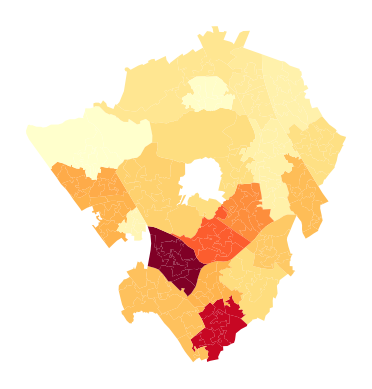

In [18]:
#Choropleth map predicted crimes

df_geopandas = gpd.GeoDataFrame(df_geopandas, crs="EPSG:4326", geometry='geometry')


df_geopandas.plot(column='predicted crimes', legend=False, cmap='YlOrRd', alpha=1.0)
plt.axis('off');
plt.savefig('./data/warddestrib.svg', format='svg', bbox_inches='tight')



In [7]:
#Choropleth map true crimes

#df_geopandas = gpd.GeoDataFrame(df_geopandas, crs="EPSG:4326", geometry='geometry')

#df_geopandas.plot(column='crimes', legend=True, cmap='YlOrRd')
#plt.title('Predicted crimes')
#plt.axis('off');


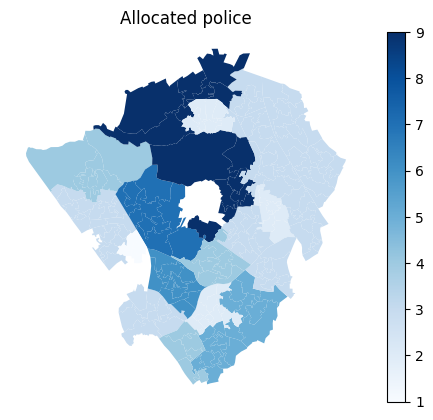

In [8]:
#Choropleth map Allocated police

df_geopandas = gpd.GeoDataFrame(df_geopandas, crs="EPSG:4326", geometry='geometry')

df_geopandas.plot(column='allocated police', legend=True, cmap='Blues')
plt.title('Allocated police')
plt.axis('off');


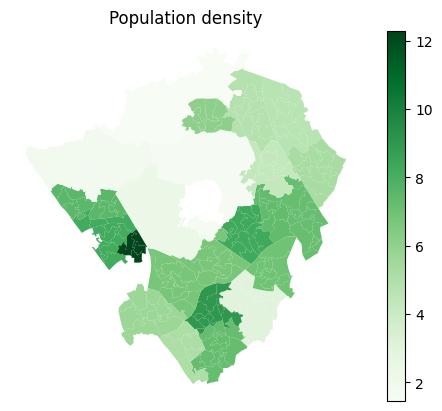

In [9]:
#Choropleth map Density

df_geopandas = gpd.GeoDataFrame(df_geopandas, crs="EPSG:4326", geometry='geometry')

df_geopandas.plot(column='People per Sq Km', legend=True, cmap='Greens')
plt.title('Population density')
plt.axis('off');

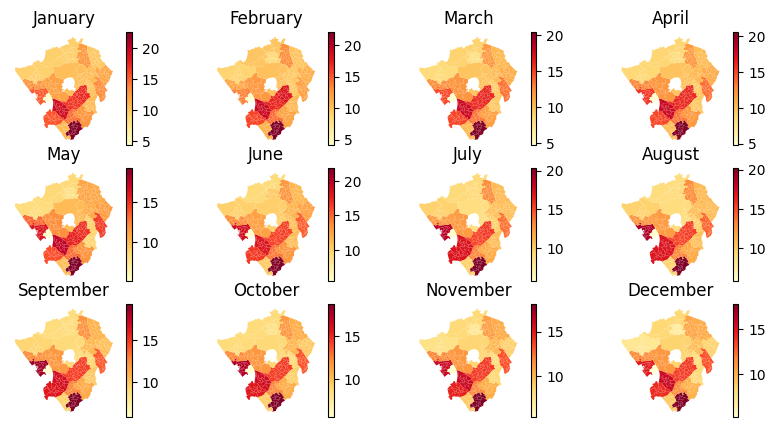

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=False, sharey='row', figsize=(10,5))
axes_list = [item for sublist in axes for item in sublist] 

amount_of_months = 12

month_names = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]

for i in range(amount_of_months):

    #Select month for crimes in Barnet wards
    crimes_in_wards = df_predicted_crimes.iloc[:,i - amount_of_months].astype(float)

    df_barnet['predicted crimes'] = crimes_in_wards


    #Calculate proportion of crimes in a ward
    df_barnet['crimes proportion'] = df_barnet['predicted crimes']*df_barnet['People per Sq Km']
    crimes_tot = df_barnet['crimes proportion'].sum()
    df_barnet['crimes proportion'] = df_barnet['crimes proportion']/crimes_tot



    #Available police force
    police_officers = 100

    #Allocate police to wards
    df_barnet['allocated police'] = calc_prob(df_barnet['crimes proportion'])


    #df_barnet['crimes proportion'] = 100*df_barnet['crimes proportion']
    #df_barnet['crimes proportion'] = df_barnet['crimes proportion'].round(0).astype(int)

    df_barnet.head()

    #Select relevant columns
    df_geopandas = pd.merge(left=df_geopandas_ward, right=df_barnet, left_on='WD22NM', right_on=df_barnet.index)

    df_geopandas = df_geopandas[['WD22NM', 'geometry', 'People per Sq Km', 'predicted crimes', 'crimes proportion', 'allocated police']]

    df_geopandas
    #DOESNT ALWAYS ADD UP TO 100!
    ax = axes_list.pop(0)
    df_geopandas = gpd.GeoDataFrame(df_geopandas, crs="EPSG:4326", geometry='geometry')

    df_geopandas.plot(ax=ax, column='predicted crimes', legend=True, cmap='YlOrRd')
    ax.axis('off')
    ax.set_title(month_names[i])




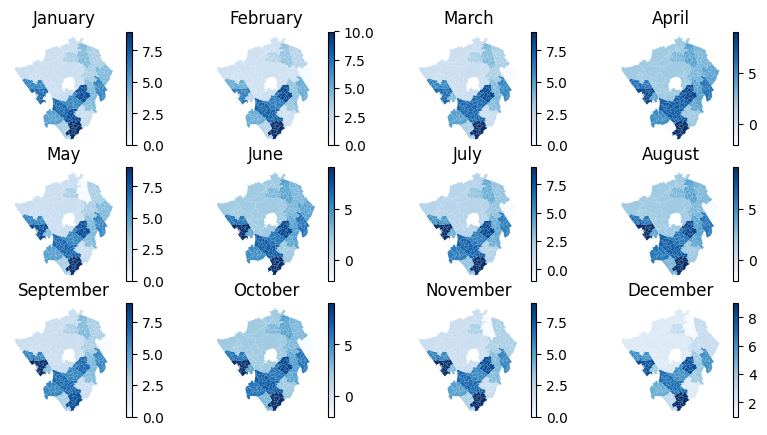

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=False, sharey='row', figsize=(10,5))
axes_list = [item for sublist in axes for item in sublist] 

amount_of_months = 12
policeman = list()


for i in range(amount_of_months):

    #Select month for crimes in Barnet wards
    crimes_in_wards = df_predicted_crimes.iloc[:,i - amount_of_months].astype(float)

    df_barnet['predicted crimes'] = crimes_in_wards


    #Calculate proportion of crimes in a ward
    df_barnet['crimes proportion'] = df_barnet['predicted crimes']*df_barnet['People per Sq Km']
    crimes_tot = df_barnet['crimes proportion'].sum()
    df_barnet['crimes proportion'] = df_barnet['crimes proportion']/crimes_tot


    #Allocate police to wards
    df_barnet['allocated police'] = calc_prob(df_barnet['crimes proportion'])



    #df_barnet['crimes proportion'] = 100*df_barnet['crimes proportion']
    #df_barnet['crimes proportion'] = df_barnet['crimes proportion'].round(0).astype(int)

    df_barnet.head()

    #Select relevant columns
    df_geopandas = pd.merge(left=df_geopandas_ward, right=df_barnet, left_on='WD22NM', right_on=df_barnet.index)

    df_geopandas = df_geopandas[['WD22NM', 'geometry', 'People per Sq Km', 'predicted crimes', 'crimes proportion', 'allocated police']]

    df_geopandas
    #DOESNT ALWAYS ADD UP TO 100!
    ax = axes_list.pop(0)
    df_geopandas = gpd.GeoDataFrame(df_geopandas, crs="EPSG:4326", geometry='geometry')

    df_geopandas.plot(ax=ax, column='allocated police', legend=True, cmap='Blues')
    ax.axis('off')
    ax.set_title(month_names[i])
    policeman.append(df_barnet['allocated police'])

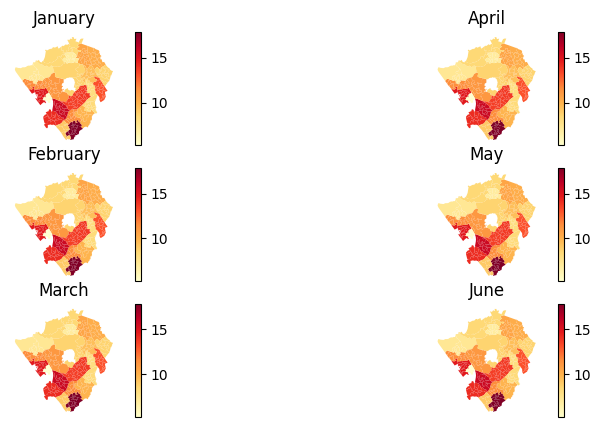

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, sharey='row', figsize=(10,5))
#axes_list = [item for sublist in axes for item in sublist] 
count = 0
for icol in range(axes.shape[1]):
    for irow in range(axes.shape[0]):
        #print(icol, irow)
            
        #Select month for crimes in Barnet wards
        crimes_in_wards = df_predicted_crimes.iloc[:,i - amount_of_months].astype(float)

        df_barnet['predicted crimes'] = crimes_in_wards


        #Calculate proportion of crimes in a ward
        df_barnet['crimes proportion'] = df_barnet['predicted crimes']*df_barnet['People per Sq Km']
        crimes_tot = df_barnet['crimes proportion'].sum()
        df_barnet['crimes proportion'] = df_barnet['crimes proportion']/crimes_tot



        #Available police force
        police_officers = 100

        #Allocate police to wards
        df_barnet['allocated police'] = calc_prob(df_barnet['crimes proportion'])


        #df_barnet['crimes proportion'] = 100*df_barnet['crimes proportion']
        #df_barnet['crimes proportion'] = df_barnet['crimes proportion'].round(0).astype(int)

        df_barnet.head()

        #Select relevant columns
        df_geopandas = pd.merge(left=df_geopandas_ward, right=df_barnet, left_on='WD22NM', right_on=df_barnet.index)

        df_geopandas = df_geopandas[['WD22NM', 'geometry', 'People per Sq Km', 'predicted crimes', 'crimes proportion', 'allocated police']]

        df_geopandas = gpd.GeoDataFrame(df_geopandas, crs="EPSG:4326", geometry='geometry')

        df_geopandas.plot(ax=axes[irow][icol], column='predicted crimes', legend=True, cmap='YlOrRd')
        axes[irow][icol].axis('off')
        axes[irow][icol].set_title(month_names[count])
        count += 4